In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
8,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
2,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
0,toy_ori,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
1,toy_w1_0.9,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
3,toy_w1_0.8,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
4,toy_w1_0.5,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
5,toy_w1.0.1,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
6,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
7,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [3]:
task = "linear_regression"
#task = "sparse_linear_regression"
# task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "toy_w1.0.1"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

run_name: linear_regression_toy, id: toy_w1.0.1
------------------------
conf: Munch({'config': 'conf/toy.yaml', 'inherit': ['/home/hlv8980/in-context-learning-fork/src/conf/models/standard.yaml', '/home/hlv8980/in-context-learning-fork/src/conf/wandb.yaml'], 'model': Munch({'family': 'gpt2', 'n_dims': 5, 'n_embd': 256, 'n_head': 8, 'n_layer': 12, 'n_positions': 11}), 'out_dir': '../models/linear_regression/77b96000-6fdf-43f1-9c4c-bf397e2195c8', 'test_run': False, 'training': Munch({'batch_size': 64, 'curriculum': Munch({'dims': Munch({'end': 5, 'inc': 1, 'interval': 2000, 'start': 5}), 'points': Munch({'end': 11, 'inc': 2, 'interval': 2000, 'start': 11})}), 'data': 'gaussian', 'keep_every_steps': 100000, 'learning_rate': 0.0001, 'num_tasks': None, 'num_training_examples': None, 'resume_id': None, 'save_every_steps': 1000, 'task': 'linear_regression', 'task_kwargs': Munch({}), 'train_steps': 5001}), 'wandb': Munch({'entity': 'northwestern-in-context-learning', 'log_every_steps': 100, '

100%|██████████| 15/15 [00:00<00:00, 277156.65it/s]

------------------------
metrics: {'standard': {'gpt2_embd=256_layer=12_head=8': {'mean': [17.361268997192383, 6.032593250274658, 3.9156699180603027, 2.3518643379211426, 1.3075495958328247, 0.859294593334198, 0.5373897552490234, 0.4059937596321106, 0.2854611277580261, 0.2298036515712738, 0.2096104621887207], 'std': [28.210424423217773, 11.14716911315918, 7.320164203643799, 4.995622158050537, 2.8699846267700195, 2.039395332336426, 1.5865399837493896, 1.2243727445602417, 1.326406478881836, 0.6389020085334778, 0.7495585083961487], 'bootstrap_low': [16.092052459716797, 5.526101112365723, 3.5980281829833984, 2.134288787841797, 1.1823768615722656, 0.7628963589668274, 0.467296838760376, 0.3534243702888489, 0.23424199223518372, 0.20341137051582336, 0.1790785789489746], 'bootstrap_high': [18.71904945373535, 6.571530342102051, 4.269782543182373, 2.6007752418518066, 1.4368278980255127, 0.9583410024642944, 0.61272132396698, 0.46282196044921875, 0.35224607586860657, 0.25973421335220337, 0.247349828

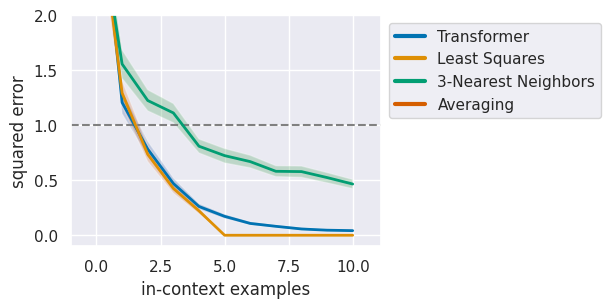

In [4]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

In [6]:
# # plot any OOD metrics
# for name, metric in metrics.items():
#     if name == "standard": continue
   
#     if "scale" in name:
#         scale = float(name.split("=")[-1])**2
#     else:
#         scale = 1.0

#     trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
#     fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
#     ax.set_title(name)
    
#     if "ortho" in name:
#         ax.set_xlim(-1, n_dims - 1)
#     ax.set_ylim(-.1 * scale, 1.5 * scale)

#     plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [8]:
from samplers import get_data_sampler
from tasks import get_task_sampler
print(conf.training.curriculum.points.end)


11


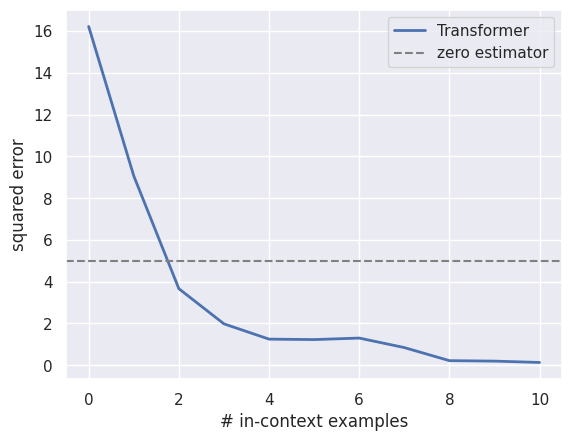

In [9]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
with torch.no_grad():
    pred = model(xs, ys)
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [10]:
# xs2 = 2 * xs
# ys2 = task.evaluate(xs2)
# with torch.no_grad():
#     pred2 = model(xs2, ys2)
    
# loss2 = metric(pred2, ys2).numpy()

# plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
# plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
# plt.xlabel("# in-context examples")
# plt.ylabel("squared error")
# plt.legend()
# plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

In [11]:
import numpy as np
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size # this is 64
n_batches = 100

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
task = task_sampler()
all_errors = []

# Generate data and perform the experiment
for _ in range(n_batches):

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=2*conf.training.curriculum.points.end-1)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)
        
    metric = task.get_metric()
    loss = metric(pred, ys).numpy()
    all_errors.append(loss)
    # error = (pred - ys) ** 2
    # all_errors.append(error.mean(axis=0).numpy())



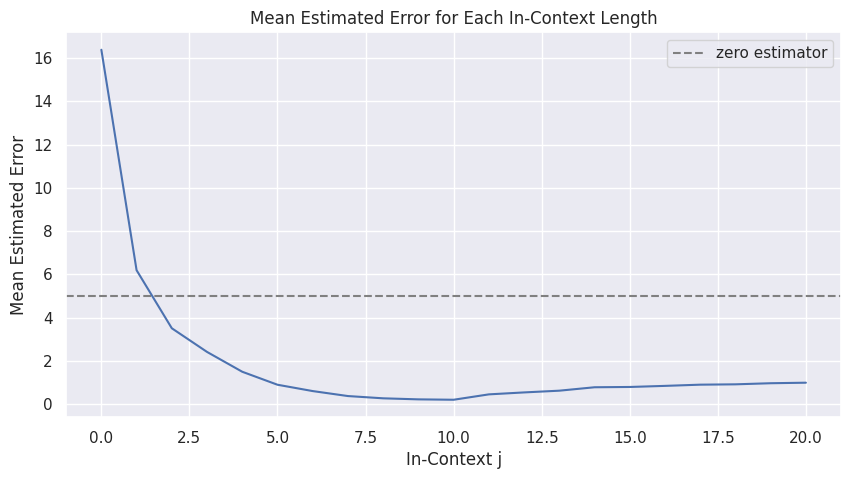

In [12]:

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

mean_errors = np.mean(all_errors, axis=(0, 1))
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.plot(range(21), mean_errors)
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.legend()
plt.xlabel('In-Context j')
plt.ylabel('Mean Estimated Error')
plt.title('Mean Estimated Error for Each In-Context Length')
plt.show()

# w1 = 0.1 w2 = 0.9